# Ranking companies

We will model the trends in H1B visa (The primary visa granted in Tech companies when hiring foreign nationals) to identify companies that hire a robust number of foreign nationals.

The [H1B visa data](https://www.uscis.gov/tools/reports-and-studies/h-1b-employer-data-hub) is from the US government but its quality is not guaranteed.

## Getting company performance

Context: choosing a company should factor in their compensation package. Companies often offer stock as a part of their compensation to align the incentives between the employee and company performance.

To get the stock information, we will leverage [the API from AlphaVantage](https://www.alphavantage.co/documentation/).
- The data under `"TIME_SERIES_MONTHLY_ADJUSTED"`
- The data type should be in the JSON format
- WARNING: The limit is 500 calls per day and 5 calls per minute for AlphaVantage's free tier.


In [ ]:
import requests
url = 'https://www.alphavantage.co/query'
stock_symbols = ["INFY", "MSFT"]
result = {}
for company in stock_symbols:
  params = {'function':'TIME_SERIES_MONTHLY_ADJUSTED',
            'symbol':company,
            'apikey':'P7Q65RAWC1INZC1S'}
  r = requests.get(url = url, params = params)
  assert r.status_code == 200, 'status code goes wrong'
  data = r.json()
  result[company] = data
  #result.update(data2)


In [ ]:
type(result)

dict

In [ ]:
result.keys()

dict_keys(['INFY', 'MSFT'])

In [ ]:
len(result)

2

## Data wrangling

Use dictionary:
```
employer2stock = {
    "INFOSYS LIMITED": "INFY",
    "ACCENTURE LLP": "ACN",
    "NTT DATA": "NTDTY",
    "MICROSOFT": "MSFT",
    "AMAZON WEB SERVICES": "AMZN",
    "INTEL": "INTC",
    "NVIDIA": "NVDA",
    "ORACLE AMERICA": "ORCL",
    "QUALCOMM TECHNOLOGIES": "QCOM",
    "VMWARE": "VMW"
}
```

Our goal is to wrangle the data into a data frame where the rows correspond to different companies and the columns are:
- `name`: The company name as in `employer2stock`, these should be strings
- `symbol`: The stock symbol as in `employer2stock`, these should be strings
- `adj_close`: The monthly adjusted close price, these should be floats
- `date`: The end date of the adjusted close price in that month, these should be datetime objects
- `year`: The year for that corresponding record, these should be integers


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path = ("/content/drive/MyDrive/stocks_monthly_adjusted.json")
import json
with open(file_path, 'r') as f:
  dat = json.load(f)

In [ ]:
type(dat)

dict

In [ ]:
dat.keys()

dict_keys(['INFY', 'ACN', 'NTDTY', 'MSFT', 'AMZN', 'INTC', 'NVDA', 'ORCL', 'QCOM', 'VMW'])

In [ ]:
dat['INFY']['Monthly Adjusted Time Series']['2022-11-29']

{'1. open': '19.1900',
 '2. high': '20.0600',
 '3. low': '18.0800',
 '4. close': '19.7100',
 '5. adjusted close': '19.7100',
 '6. volume': '122531429',
 '7. dividend amount': '0.0000'}

In [ ]:
import pandas as pd
from datetime import datetime
employer2stock = {
    "INFOSYS LIMITED": "INFY",
    "ACCENTURE LLP": "ACN",
    "NTT DATA": "NTDTY",
    "MICROSOFT": "MSFT",
    "AMAZON WEB SERVICES": "AMZN",
    "INTEL": "INTC",
    "NVIDIA": "NVDA",
    "ORACLE AMERICA": "ORCL",
    "QUALCOMM TECHNOLOGIES": "QCOM",
    "VMWARE": "VMW"
}
transformed_data = []
for company_name, symbol in employer2stock.items():
  if symbol in dat:
    for date_str, info in dat[symbol]['Monthly Adjusted Time Series'].items():
      record = {
          'name': company_name,
          'symbol': symbol,
          'adj_close': float(info['5. adjusted close']),
          'date': datetime.strptime(date_str, '%Y-%m-%d'),
          'year': datetime.strptime(date_str, '%Y-%m-%d').year
      }
      transformed_data.append(record)

stocks_df = pd.DataFrame(transformed_data)

In [ ]:
stocks_df.shape

(2533, 5)

In [ ]:
stocks_df[:3]

,name,symbol,adj_close,date,year
0,INFOSYS LIMITED,INFY,19.7100,2022-11-29,2022
1,INFOSYS LIMITED,INFY,18.7300,2022-10-31,2022
2,INFOSYS LIMITED,INFY,16.7875,2022-09-30,2022


In [ ]:
stocks_df.dtypes

name                 object
symbol               object
adj_close           float64
date         datetime64[ns]
year                  int64
dtype: object

## Summarize data

Summarize `stocks_df` into a data frame, called `stocks_summ`, where the rows correspond to a year and company pair and the columns correspond to:  
- `name`: The company name as in `employer2stock`
- `symbol`: The stock symbol as in `employer2stock`
- `year`: The year
- `avg_adj_close`: The average monthly adjusted close price in the corresponding year
- `std_adj_close`: The standard deviation of the monthly adjusted close price in the corresponding year


In [ ]:
stocks_summ = stocks_df.groupby(['name', 'symbol', 'year']).agg(
    avg_adj_close=('adj_close', 'mean'),
    std_adj_close=('adj_close', 'std')
).reset_index()

In [ ]:
stocks_summ.shape

(220, 5)

In [ ]:
stocks_summ[:3]

,name,symbol,year,avg_adj_close,std_adj_close
0,ACCENTURE LLP,ACN,2001,13.68820,4.174862
1,ACCENTURE LLP,ACN,2002,14.52705,3.019500
2,ACCENTURE LLP,ACN,2003,14.24110,2.765393


## Filtering

Given most of our students are foreign nationals, the number of H1B visas assigned to each company is useful. This is the primary work visa applied by Tech companies to hire foreign nationals.

Please find `h1bexports.csv`, a processed version of data from [H1B DataHub](https://www.uscis.gov/tools/reports-and-studies/h-1b-employer-data-hub). Each row corresponds to a unique fiscal year and employer combination and the columns are:
- `Fiscal Year`: Oct 1 of the year to Sept 30 the next year.
- `Employer`: the employer filing for the H1B visa
- `Initial Approval`: the number of newly applied H1B visas that are approved
- `Initial Denial`: the number of newly applied H1B visas that are denied
- `Continuing Approval`: the number of H1B visas approved in the past that is again approved this year
- `Continuing Denial`: all remaining H1B visas applications not included in the 3 categories above
If you wish, more details can be read [here](https://www.uscis.gov/tools/reports-and-studies/h-1b-employer-data-hub/understanding-our-h-1b-employer-data-hub)

- Create a data frame call `friendly` that filters the data such that we only have companies that satisfy the following conditions:
  - They have at least 10 years worth of H1B visas being newly approved, these years do NOT need to be consecutive
  - They have at least 1 newly approved H1B visas in both 2021 and 2022
- Report how many companies satisfy these criteria in a human readable message (You do not need to articulate the condition these companies satisfy).

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/h1bexports.csv')

In [ ]:
df.head()

,Fiscal Year,Employer,Initial Approval,Initial Denial,Continuing Approval,Continuing Denial
0,2009,& TV COMMUNICATIONS,1,0,0,0
1,2009,1 800 GIFT CERTIFICATES LLC DBA,1,0,2,0
2,2009,1 DEVELOPMENT CONSTRUCTION,0,0,0,1
3,2009,1 I L INC DOING BUSINESS AS,1,0,0,0
4,2009,1 RED W TRADING,0,0,1,0


In [ ]:
# companies_2021_2022 = df[(df['Fiscal Year'].isin([2021, 2022])) & (df['Initial Approval'] > 0)]
# companies_2021_2022 = companies_2021_2022.groupby('Employer').filter(lambda x: len(x) == 2)
# companies_10_years = df[df['Initial Approval'] > 0].groupby('Employer').filter(lambda x: x['Fiscal Year'].nunique() >= 10)
# friendly = pd.merge(companies_2021_2022, companies_10_years, on=['Employer', 'Fiscal Year'], how='inner').drop_duplicates('Employer')
# num_companies = len(friendly['Employer'].unique())

In [ ]:
newly_approved_non_zero = df[(df['Fiscal Year'].isin([2021, 2022])) & (df['Initial Approval'] > 0)]

In [ ]:
companies_eligible1 = newly_approved_non_zero['Employer'].unique()

In [ ]:
companies_eligible1

array(['01INTERACTIVE', '02908 HOLDCO', '0965688 BC LTD DBA PROCOGIA',
       ..., 'ZYLTECH ENGINEERING', 'ZYMTRONIX CATALYTIC SYSTEMS',
       'ZYNEX MEDICAL'], dtype=object)

In [ ]:
eligible_data = df[df['Employer'].isin(companies_eligible1)]

In [ ]:
eligible_data['Employer'].value_counts()

UNISYS                         14
GLOBAL PRIOR ART               14
TEKNEST                        14
TEKLINK INTERNATIONAL          14
TEKFORCE                       14
                               ..
OBRA DESIGN STUDIO              1
OBVIOUSLEE MARKETING            1
OC LAW GROUP                    1
OCEAN GENOMICS                  1
ZYMTRONIX CATALYTIC SYSTEMS     1
Name: Employer, Length: 36004, dtype: int64

In [ ]:
#finding companies in 10 years
companies_10_years = eligible_data[eligible_data['Initial Approval'] > 0].groupby('Employer').filter(lambda x: x['Fiscal Year'].nunique() >= 10)

In [ ]:
friendly = companies_10_years

In [ ]:
num_companies = len(friendly['Employer'].unique())

In [ ]:
num_companies

2931

In [ ]:
friendly.head()

,Fiscal Year,Employer,Initial Approval,Initial Denial,Continuing Approval,Continuing Denial
87,2009,22ND CENTURY TECHNOLOGIES,9,4,12,3
143,2009,3A SOFT,2,0,0,0
150,2009,3CORE SYSTEMS,2,3,5,0
163,2009,3I INFOTECH,10,0,10,0
169,2009,3K TECHNOLOGIES,3,1,13,0


In [ ]:
friendly['Fiscal Year'].value_counts()

2021    2755
2020    2664
2014    2653
2019    2618
2015    2602
2016    2601
2013    2582
2018    2566
2012    2523
2017    2475
2022    2376
2011    2275
2009    1994
2010    1942
Name: Fiscal Year, dtype: int64

## Joining

- Join `friendly` and `stocks_summ` by year and company name into a data frame called `jdf`, keeping only records that exist in both sources. Please print out the number of rows in `jdf` in a human readable message.
  - Fiscal year 2021 in `friendly` should be joined with `year` 2021 in `stocks_summ` for the sake of the exam. Don't overthink this.
- Make `jdf` only have the columns `year`, `name`, `avg_adj_close`, `std_adj_close`, and `Initial Approval`.

In [ ]:
friendly.head(2)

,Fiscal Year,Employer,Initial Approval,Initial Denial,Continuing Approval,Continuing Denial
87,2009,22ND CENTURY TECHNOLOGIES,9,4,12,3
143,2009,3A SOFT,2,0,0,0


In [ ]:
stocks_summ.head(2)

,name,symbol,year,avg_adj_close,std_adj_close
0,ACCENTURE LLP,ACN,2001,13.68820,4.174862
1,ACCENTURE LLP,ACN,2002,14.52705,3.019500


In [ ]:
friendly.shape

(34626, 6)

In [ ]:
stocks_summ.shape

(220, 5)

In [ ]:
jdf = pd.merge(
    friendly,
    stocks_summ,
    left_on=['Fiscal Year', 'Employer'],
    right_on=['year', 'name'],
    how='inner'  # 'inner' to keep only records that exist in both DataFrames
)

In [ ]:
jdf.head()

,Fiscal Year,Employer,Initial Approval,Initial Denial,Continuing Approval,Continuing Denial,name,symbol,year,avg_adj_close,std_adj_close
0,2009,ACCENTURE LLP,48,7,105,1,ACCENTURE LLP,ACN,2009,26.194250,3.788389
1,2009,AMAZON WEB SERVICES,1,0,1,0,AMAZON WEB SERVICES,AMZN,2009,4.536542,1.277117
2,2009,INTEL,818,2,494,8,INTEL,INTC,2009,11.427517,1.944207
3,2009,MICROSOFT,1505,7,1790,19,MICROSOFT,MSFT,2009,17.584392,3.698794
4,2009,NVIDIA,150,1,132,0,NVIDIA,NVDA,2009,2.782425,0.692122


In [ ]:
jdf.head(3)

,Fiscal Year,Employer,Initial Approval,Initial Denial,Continuing Approval,Continuing Denial,name,symbol,year,avg_adj_close,std_adj_close
0,2009,ACCENTURE LLP,48,7,105,1,ACCENTURE LLP,ACN,2009,26.194250,3.788389
1,2009,AMAZON WEB SERVICES,1,0,1,0,AMAZON WEB SERVICES,AMZN,2009,4.536542,1.277117
2,2009,INTEL,818,2,494,8,INTEL,INTC,2009,11.427517,1.944207


In [ ]:
jdf.shape

(130, 11)

## SQL

If `friendly` and `stocks_summ` were tables in an SQL database called `"h1b"`, how would the join in Q5 look in an SQL query? Pretend any space in a variable  name is replaced with an underscore, i.e. `"Initial Approval"` would be a column named `"Initial_Approval"` in this database.

In [ ]:
query = """
SELECT
    s.year,
    s.name,
    s.avg_adj_close,
    s.std_adj_close,
    f.Initial_Approval
FROM
    friendly f
INNER JOIN
    stocks_summ s ON f.Fiscal_Year = s.year AND f.Employer = s.name;


"""

## Modeling trends

- For each employer in `jdf`, fit 2 models for `Initial Approval` using oridinary least squares regression, but limited to data in 2020 and earlier. The models should be:
  - Model 1 should regress on `year`, `avg_adj_close`, and `std_adj_close`
  - Model 2 should regress on `year` alone.
- Show which model predicts the outcomes in 2021 better with a metric.
- From the winning model, store the coefficient corresponding to `Fiscal Year` (we'll call this the "trend") and the prediction at year 2021.
- For clarification, `pred_2021` is the linear model predictions of `Initial Approval` in 2021

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

In [ ]:
jdf_2020 = jdf[jdf['year'] <= 2020]

In [ ]:
(jdf['year'] <= 2020).sum()

110

In [ ]:
jdf.year.value_counts()

2013    10
2014    10
2015    10
2016    10
2017    10
2018    10
2019    10
2020    10
2021    10
2022    10
2012     9
2009     7
2010     7
2011     7
Name: year, dtype: int64

In [ ]:
employers = jdf_2020['name'].unique()
output = []

In [ ]:
len(employers)

10

In [ ]:
jdf_2020.name.value_counts()

ACCENTURE LLP            12
AMAZON WEB SERVICES      12
INTEL                    12
MICROSOFT                12
NVIDIA                   12
ORACLE AMERICA           12
VMWARE                   12
INFOSYS LIMITED           9
NTT DATA                  9
QUALCOMM TECHNOLOGIES     8
Name: name, dtype: int64

In [ ]:
for employer in employers:
    employer_data = jdf_2020[jdf_2020['name'] == employer]
    X1 = employer_data[['year', 'avg_adj_close', 'std_adj_close']]
    X2 = employer_data[['year']]
    y = employer_data['Initial Approval']
    model1 = LinearRegression().fit(X1, y)
    model2 = LinearRegression().fit(X2, y)

    employer_data_2021 = jdf[(jdf['name'] == employer) & (jdf['year'] == 2021)]
    X1_2021 = employer_data_2021[['year', 'avg_adj_close', 'std_adj_close']]
    X2_2021 = employer_data_2021[['year']]
    y_true_2021 = employer_data_2021['Initial Approval']

    y_pred1_2021 = model1.predict(X1_2021)
    y_pred2_2021 = model2.predict(X2_2021)

    rmse1 = np.sqrt(mean_squared_error(y_true_2021, y_pred1_2021))
    rmse2 = np.sqrt(mean_squared_error(y_true_2021, y_pred2_2021))

    better_model = "Model 1" if rmse1 < rmse2 else "Model 2"
    trend = model1.coef_[0] if better_model == "Model 1" else model2.coef_[0]
    pred_2021 = y_pred1_2021[0] if better_model == "Model 1" else y_pred2_2021[0]

    output.append({'name': employer, 'trend': trend, 'pred_2021': pred_2021})

In [ ]:
output

[{'name': 'ACCENTURE LLP',
  'trend': -14.727272727272737,
  'pred_2021': 1505.9393939393958},
 {'name': 'AMAZON WEB SERVICES',
  'trend': -3.340321014582969,
  'pred_2021': 750.3297278288655},
 {'name': 'INTEL', 'trend': 41.15606715990209, 'pred_2021': 916.6596576186712},
 {'name': 'MICROSOFT',
  'trend': 0.5104895104895141,
  'pred_2021': 1391.651515151515},
 {'name': 'NVIDIA',
  'trend': 10.290209790209786,
  'pred_2021': 217.9696969696961},
 {'name': 'ORACLE AMERICA',
  'trend': 32.1118881118881,
  'pred_2021': 540.2272727272721},
 {'name': 'VMWARE',
  'trend': 10.762237762237758,
  'pred_2021': 189.45454545454413},
 {'name': 'INFOSYS LIMITED',
  'trend': 72.73333333333332,
  'pred_2021': 1576.444444444467},
 {'name': 'NTT DATA',
  'trend': -22.186479647042813,
  'pred_2021': 64.23399332405825},
 {'name': 'QUALCOMM TECHNOLOGIES',
  'trend': -19.869047619047628,
  'pred_2021': 279.4642857142826}]

In [ ]:
rmse1

504.9807534710271

In [ ]:
rmse2

130.5357142857174

In [ ]:
better_model

'Model 2'

## Visualization

- Visualize the relationship between `trend` and `pred_2021` across the companies in `output`.
- Add informative x and y axis labels in the figure
- Report the Pearson correlation between `trend` and `pred_2021`.

In [ ]:
df_output = pd.DataFrame(output)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr


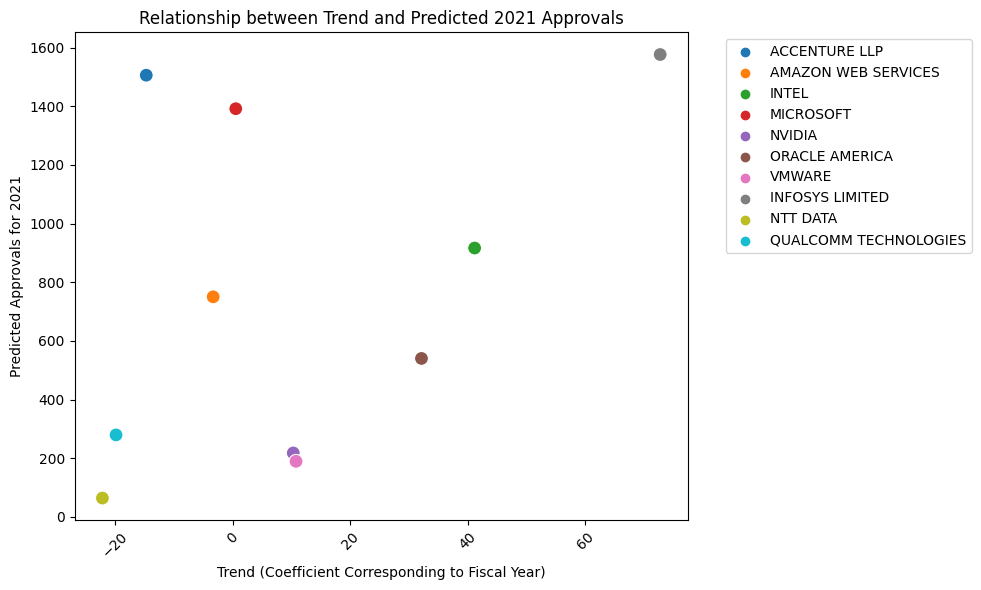

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='trend', y='pred_2021', data=df_output, hue='name', s=100)
plt.title('Relationship between Trend and Predicted 2021 Approvals')
plt.xlabel('Trend (Coefficient Corresponding to Fiscal Year)')
plt.ylabel('Predicted Approvals for 2021')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# Pearson correlation
corr, _ = pearsonr(df_output['trend'], df_output['pred_2021'])
corr_message = f'The Pearson correlation between trend and predicted approvals for 2021 is {corr:.2f}.'

corr_message

'The Pearson correlation between trend and predicted approvals for 2021 is 0.40.'

## Objective functions

Let's pretend Handshake (a recruiting company) decided to score all of the employers given some inputs. These scores for each employer is stored into a 1 dimensional numpy array called `ds`.

- (NO CODE) Please articulate what inputs do you wish Handshake used in their scoring? Please list at least 3 reasonable inputs that do not overlap.
  - In the following questions, we will pretend each of these inputs are in a 1 dimensional numpy array called `x1`, `x2`, and `x3` that are aligned with `ds`.
- Let's pretend that the scores can be approximated with a linear combination of the inputs. But for students, scoring a company lower than it should is worse than scoring a company higher than it should be, i.e. we do not want to miss a good company but applying to an undesirable company is not a big deal. **Write an objective function**, `obj()` that will guide us in modeling the scores using the inputs.

  - We should pretend the initial conditions is just a variable called `init_x`

In [ ]:
#question 1: we can use employee satisfiction rating, growth oppotunities, and company stability and market position

In [ ]:
import numpy as np
from scipy.optimize import minimize

In [ ]:
def obj(params, x1, x2, x3):
  beta0 = params[0]
  beta1 = params[1]
  beta2 = params[2]
  predicted_scores = beta0 * x1 + beta1 * x2 + beta2 * x3
  under_estimation = 2
  over_estimation = 1
  loss = np.where(predicted_scores < ds,
                    under_estimation * (ds - predicted_scores) ** 2,
                    over_estimation * (predicted_scores - ds) ** 2)
  total_loss = np.sum(loss)
  return total_loss
init_x = np.array([0.5, 0.5, 0.5])
result = minimize(obj, init_x)
optimized_params = result.x